In [1]:
 #Importing Libraries
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_auc_score, RocCurveDisplay,roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
import string
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import time
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from itertools import cycle

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv('/workspaces/codespaces-blank/news_classification/data/train.csv')
test_df = pd.read_csv('/workspaces/codespaces-blank/news_classification/data/valid.csv')
train_df.head(5)

,ArticleId,Text,Category
0,1155,chancellor rallies labour voters gordon brown ...,politics
1,1980,india s maruti sees profits jump india s bigge...,business
2,386,ukip s secret weapon by any measure new york...,politics
3,1436,banker loses sexism claim a former executive a...,business
4,304,dallaglio eyeing lions tour place former engla...,sport


In [3]:
train_df.shape

(1043, 3)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1043 non-null   int64 
 1   Text       1043 non-null   object
 2   Category   1043 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.6+ KB


In [5]:
train_df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [6]:
target_names = train_df['Category'].unique().tolist()
target_names

['politics', 'business', 'sport', 'entertainment', 'tech']

In [7]:
print(train_df.iloc[0,1])
print(train_df.iloc[30,1])
print(train_df.iloc[245,1])

chancellor rallies labour voters gordon brown has issued a rallying cry to supporters  warning the  stakes are too high  to stay at home or protest vote in the next general election.  the chancellor said the poll - expected to fall on 5 may - would give a  clear and fundamental  choice between labour investment and tory cuts. he told his party s spring conference the tories must not be allowed to win. the conservatives and lib dems insisted that voters faced higher taxes and means-testing under labour.  to a packed audience at gateshead s sage centre  mr brown accused shadow chancellor oliver letwin of plotting cuts that were the equivalent of sacking every teacher  gp and nurse in the country. laying into the conservative s record in government he said:  i give you this promise - with labour  britain will never return to the mistakes of erm and 10% inflation  15% interest rates  £3bn in lost reserves  250 000 repossessed  one million in negative equity and three million unemployed.  n

In [8]:
counts = train_df['Category'].value_counts()
for col in target_names:
    col_sum = counts[col]
    print(f'Total no of {col}_is {col_sum}')

Total no of politics_is 196
Total no of business_is 235
Total no of sport_is 250
Total no of entertainment_is 178
Total no of tech_is 184


## CLEANING

In [9]:
def preprocessor(text):
    '''
    explain func
    '''
    text = text.lower() #Lowers  the text
    text = re.sub('<[^>]*>', '', text) # removes HTML Markup
    text = re.sub(r'[^a-zA-Z\s]', '', text) # removes special characters and digits
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words and word not in string.punctuation] #removes stopwords
    text = ' '.join(word for word in text)
    return text

In [10]:
train_df['Text'] = train_df['Text'].apply(preprocessor)
train_df.loc[0,'Text']

'chancellor rallies labour voters gordon brown issued rallying cry supporters warning stakes high stay home protest vote next general election chancellor said poll expected fall may would give clear fundamental choice labour investment tory cuts told party spring conference tories must allowed win conservatives lib dems insisted voters faced higher taxes meanstesting labour packed audience gateshead sage centre mr brown accused shadow chancellor oliver letwin plotting cuts equivalent sacking every teacher gp nurse country laying conservative record government said give promise labour britain never return mistakes erm inflation interest rates bn lost reserves repossessed one million negative equity three million unemployed never tory boom bust central dividing line election conservative party taking britain back planning deep cuts bn services labour government taking britain forward platform stability reform renew hospitals schools public services proud say spend bn turning economy chan

In [11]:
x_train = train_df['Text']
y_train = train_df['Category']

In [12]:
tf_idf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 10)
x_train_transform = tf_idf_vectorizer.fit_transform(x_train)
print(x_train_transform.shape)
tfidf_dataframe = pd.DataFrame(x_train_transform.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
tfidf_dataframe.head()

(1043, 3085)


,ability,able,abroad,absence,absolutely,abuse,academy,accept,accepted,access,...,years,yen,yes,yet,york,young,younger,yukos,zealand,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023486,0.0,0.0,0.0,0.0,0.07663,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035921,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047386,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.105149,0.0


### Modelling

In [13]:
pipe = Pipeline([("tf-idf", TfidfVectorizer(max_df= 0.8, min_df= 10)), 
                ('svm_model',SVC(random_state=10, probability=True))])
%time pipe.fit(x_train, y_train)

CPU times: user 7.82 s, sys: 8.33 ms, total: 7.83 s
Wall time: 8.03 s


Pipeline(steps=[('tf-idf', TfidfVectorizer(max_df=0.8, min_df=10)),
                ('svm_model', SVC(probability=True, random_state=10))])

In [14]:
#test
x_test = test_df['Text'].apply(preprocessor)
y_test = test_df['Category']
%time y_pred = pipe.predict(x_test)

CPU times: user 243 ms, sys: 216 µs, total: 243 ms
Wall time: 246 ms


In [15]:
def model_score(Y_test, Y_pred, Y_pred_prob, classes = None):
    print(f'Accuracy Score : {accuracy_score(Y_test, Y_pred)}')
    #auc score 
    print(f'AUC Score : {roc_auc_score(Y_test, Y_pred_prob, multi_class="ovr")}')
    cm = confusion_matrix(Y_test, Y_pred, labels= classes)
    disp = ConfusionMatrixDisplay(confusion_matrix= cm , display_labels= classes)
    fig , ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, xticks_rotation= 'vertical')
    plt.show()


In [ ]:
y_pred_prob = pipe.predict_proba(x_test)
model_score(y_test, y_pred, y_pred_prob, classes = pipe.classes_)

## ROC CURVE

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer =  LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)
print(y_test_bin.shape)
label_binarizer.transform(['sport'])

(223, 5)


array([[0, 0, 0, 1, 0]])

In [ ]:
class_of_interest = 'politics'
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

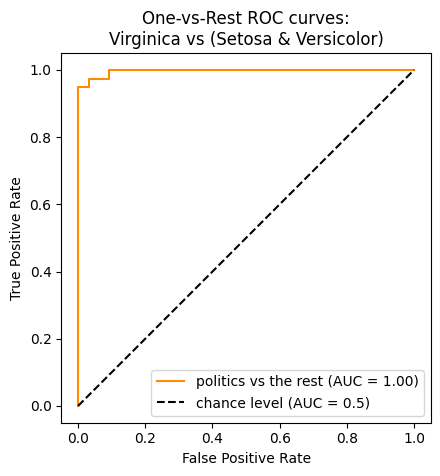

In [ ]:
RocCurveDisplay.from_predictions(y_test_bin[:,class_id], y_pred_prob[:,class_id],
 name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
def multi_class_roc_curve(Y_test_Binarizer = None, Y_prob = None, Title = None, classes = None):
    '''
    explain func
    '''
    #n_classes = len(np.unique(y))
    n_classes = len(classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(Y_test_Binarizer[:,class_id], Y_prob[:,class_id] 
                                         , name=f"ROC curve for {classes[class_id]}"
                                         , color=color, ax=ax,)
        
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for random chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.show()

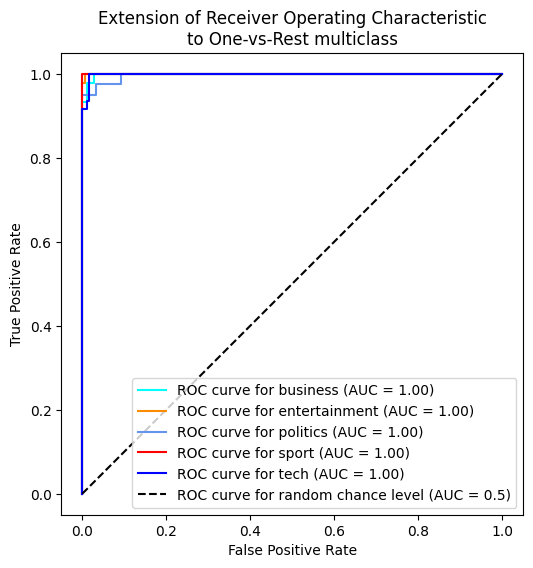

In [ ]:

multi_class_roc_curve(y_test_bin, y_pred_prob, classes = pipe.classes_) 

# FINAL TEST

In [ ]:
def makecsv(id_test, test_y_pred):
    #change the ans label
    #test_y_pred = number_to_label(test_y_pred)
    submission = {'ArticleId': id_test, 'Category': test_y_pred}
    submission = pd.DataFrame(submission)
    submission.to_csv('./submission.csv', index=0, header=1)

In [ ]:
final_test_df = pd.read_csv('/workspaces/codespaces-blank/news_classification/data/test.csv')
final_test_df['Text'] = final_test_df['Text'].apply(preprocessor)
final_y = tf_idf_vectorizer.transform(final_test_df['Text'])
print(final_y.shape)
final_y_pred = base_svm_model.predict(final_y)
makecsv(final_test_df['ArticleId'], final_y_pred)

(224, 3085)


NameError: name 'base_svm_model' is not defined